In [66]:
import re
import pandas as pd
from wordfreq import zipf_frequency
import csv
import matplotlib.pyplot as plt
import json
from collections import Counter, defaultdict
#pip install transformers
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

Начинаю с первичного анализа (EDA),что поможет понять структуру данных, их длины, разнообразие, потенциальные сложности (бренды, города, цифры и т.д.):

При загрузке датасета было замечено, что есть лишние запятые внутри текста (например - 100,ищукнигубратьякарамазовы,срочно), и если просто грузить через pd.read_csv, то Pandas думает, что это три колонки, а не одна (id,text_no_spaces).

Тогда напишу функцию load_dataset_with_summary, которая открывает файл как CSV и аккуратно склеивает все части текста обратно, если внутри были запятые + дает доп информацию:

размер датасета,
длины строк (min, max, mean)
количество строк с цифрами, латиницей, заглавными буквами


Также определяю эвристики (правилa разбиения слов, которые работают в большинстве случаев). Они помогают алгоритму справляться с ситуациями, где обычная модель (n-граммы, частоты) может ошибаться.

C помощью EDA можно понять, cколько примеров могут требовать эвристик (Было выяснено: Строк с цифрами: 26, Строк с заглавными буквами: 589, Строк с латиницей: 90)



In [67]:
def load_dataset_with_summary(path: str) -> pd.DataFrame:
    rows = []
    with open(path, encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:  # пустая строка
                continue
            if row[0] == "id":  # пропускаем заголовок
                continue
            id_ = int(row[0])  # id → число
            text = ",".join(row[1:])  # склеиваем обратно
            # приведение первой буквы к нижнему регистру
            if text:
                text = text[0].lower() + text[1:]
            rows.append((id_, text))
    
    df = pd.DataFrame(rows, columns=["id", "text_no_spaces"])
    # df = df.set_index("id")  # id становится индексом
    
    # Добавляем длину строк
    df["length"] = df["text_no_spaces"].str.len()
    
    # Дополнительные признаки
    has_digits = df["text_no_spaces"].str.contains(r"\d").sum()
    has_upper = df["text_no_spaces"].str.contains(r"[А-Я]").sum()
    has_latin = df["text_no_spaces"].str.contains(r"[A-Za-z]").sum()

    # Мини-EDA
    print("Сводка по датасету")
    print("Размер датасета:", df.shape)
    print("Средняя длина:", df["length"].mean())
    print("Мин длина:", df["length"].min())
    print("Макс длина:", df["length"].max())
    print("Строк с цифрами:", has_digits)
    print("Строк с заглавными буквами:", has_upper)
    print("Строк с латиницей:", has_latin)
    print()
    print(df.info())
    
    return df

In [68]:
df = load_dataset_with_summary("Downloads/dataset_1937770_3.txt")
df.head()

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 55
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,length
0,0,куплюайфон14про,15
1,1,ищудомвПодмосковье,18
2,2,сдаюквартирусмебельюитехникой,29
3,3,новыйдивандоставканедорого,26
4,4,отдамдаромкошку,15


In [69]:
# посмотреть строки с 100 по 110, где были запятые в предложениях - убеждаеся что все верно разбито
df.iloc[100:111]

,id,text_no_spaces,length
100,100,"ищукнигубратьякарамазовы,срочно",31
101,101,"новыймонитор,27дюймов,доставка",30
102,102,"куплюковрикдляйоги,недорого!",28
103,103,"ищуинструкторапоплаванию,бассейнрядом",37
104,104,"сдамкомнату,толькодевушке",25
105,105,"куплюшвейнуюмашинку,рабочую",27
106,106,"ищудрузейдляпутешествий,летомвгоры",34
107,107,"новаякофеваркаPhilips,гарантияесть",34
108,108,"куплюлыжи,палкивкомплекте",25
109,109,"ищуучителяповокалу,джаз",23


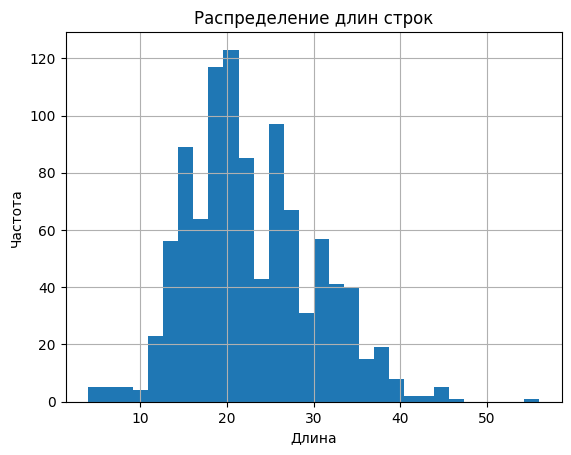

In [70]:
df["length"].hist(bins=30)
plt.title("Распределение длин строк")
plt.xlabel("Длина")
plt.ylabel("Частота")
plt.show()

In [175]:
def space_indices(s_spaced: str) -> list[int]:
    """Вернёт индексы ПРОБЕЛОВ для строки с пробелами в координатах безпробельной строки."""
    idxs, pos = [], 0
    for ch in s_spaced:
        if ch == ' ':
            idxs.append(pos)
        else:
            pos += 1
    return idxs

def indices_to_text(s_no: str, idxs: set[int]) -> str:
    out = []
    for i, ch in enumerate(s_no):
        if i in idxs: out.append(' ')
        out.append(ch)
    return ''.join(out)

def f1_sets(gold: set[int], pred: set[int]) -> float:
    tp = len(gold & pred); fp = len(pred - gold); fn = len(gold - pred)
    if tp == 0: return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * precision * recall / (precision + recall)


def make_submission(baseline_path: str, out_path: str = "submission.csv"):
    # Загружаем baseline (где есть id и indices)
    df = pd.read_csv(baseline_path)

    # Оставляем только нужные столбцы
    df = df[["id", "indices"]].rename(columns={"indices": "predicted_positions"})

    # Приводим к строке без пробелов внутри списка
    df["predicted_positions"] = df["predicted_positions"].apply(
        lambda x: x.replace(" ", "") if isinstance(x, str) else str(x)
    )

    # Сохраняем
    df.to_csv(out_path, index=False)
    print(f"✅ Submission сохранён в {out_path}")
    return df

In [72]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

#Загружаем модель = zero-shot использование Zero-shot (без дообучения)
#Инструкционный T5/mT5/ruT5 как генератор
model_name = "ai-forever/ruT5-base"
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
pipe = pipeline("text2text-generation", model=model, tokenizer=tok, device=-1)

Device set to use cpu


In [8]:
# === Словарь брендов и ключевых слов ===
BRANDS = [
    "Apple", "Samsung", "Xiaomi", "Huawei", "Honor", "Nokia", "Sony",
    "LG", "HTC", "Motorola", "Realme", "OnePlus", "Oppo", "Meizu",
    "Google", "Asus", "Lenovo", "Acer", "Dell", "HP", "MSI", "Razer",
    "Microsoft", "Panasonic", "Philips", "Sharp", "Toshiba", "BlackBerry",
    "Canon", "Nikon", "Fujifilm", "Olympus", "Leica", "GoPro", "DJI", 
    "Bosch", "Siemens", "Miele", "Electrolux", "Zanussi", "Indesit",
    "Hotpoint", "Whirlpool", "Beko", "Gorenje", "Kuppersberg", "Haier",
    "Yamaha", "Fender", "Gibson", "Ibanez", "Casio", "Roland", "Korg",
    "Marshall", "Shure", "Sennheiser", "JBL", "Behringer", "AKG",
    "BMW", "Mercedes", "Audi", "Volkswagen", "Skoda", "Porsche",
    "Lexus", "Toyota", "Mazda", "Honda", "Mitsubishi", "Subaru",
    "Suzuki", "Nissan", "Infiniti", "Acura", "Hyundai", "Kia",
    "Peugeot", "Renault", "Citroen", "Opel", "Fiat", "Jeep",
    "Chery", "Geely", "Lada", "UAZ", "Volvo", "Jaguar", "Land Rover",
    "Nike", "Adidas", "Puma", "Reebok", "Under Armour", "New Balance",
    "Columbia", "The North Face", "Patagonia", "Timberland", "Crocs",
    "Converse", "Vans", "Levi's", "Wrangler", "Zara", "H&M", "Uniqlo",
    "IKEA", "Hoff", "Leroy Merlin", "Castorama", "Decathlon"
]

# Регулярка: ищем бренды без пробелов
BRAND_PATTERN = re.compile(r"(" + "|".join(BRANDS) + r")", re.IGNORECASE)

# === Эвристика с брендами ===
def heuristic_segment(s: str) -> str:
    s = re.sub(r"(?<=\D)(\d+)", r" \1", s)     # пробел перед цифрами
    s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)      # пробел после цифр
    s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s) # пробел перед заглавной буквой
    s = BRAND_PATTERN.sub(r" \1 ", s)          # пробелы вокруг брендов
    return " ".join(s.split())                 # убрать лишние пробелы


# === Батчевый запуск с fallback ===
def batch_segment(texts: list[str]) -> list[str]:
    outs = pipe(
        texts,
        max_new_tokens=64,
        num_beams=1,
        do_sample=False,
        batch_size=8
    )
    results = []
    for inp, o in zip(texts, outs):
        gen = " ".join(o["generated_text"].split())
        # если модель дала ерунду → fallback
        if len(gen) < len(inp) or gen.count(" ") < 1 or gen.count(gen.split()[0]) > 3:
            gen = heuristic_segment(inp)
        results.append(gen)
    return results

#Прогоняем батчами
results = []
batch_size = 16

for start in range(0, len(df), batch_size):
    batch = df.iloc[start:start+batch_size]
    spaced_texts = batch_segment(batch["text_no_spaces"].tolist())
    for row, spaced in zip(batch.to_dict("records"), spaced_texts):
        idxs = space_indices(spaced)
        results.append({
            "id": row["id"],
            "text_no_spaces": row["text_no_spaces"],
            "spaced_text": spaced,
            "indices": json.dumps(idxs, ensure_ascii=False)
        })

In [9]:
out_df = pd.DataFrame(results)
out_df.to_csv("avito_segmented.csv", index=False)
#Fine-tuning нужен только если хочешь ещё лучше качество (и готова возиться с обучением).
#Эвристики можно применить в любом случае как «дополнительный фильтр».

In [10]:
pd.read_csv("avito_segmented.csv")

,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплюайфон 14 про,"[10, 12]"
1,1,ищудомвПодмосковье,ищудомв Подмосковье,[7]
2,2,сдаюквартирусмебельюитехникой,сдаюквартирусмебельюитехникой,[]
3,3,новыйдивандоставканедорого,в в ни ни ни ни ни ни ни ни ни ни ни ни ни ни ...,"[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24..."
4,4,отдамдаромкошку,отдамдаромкошку,[]
...,...,...,...,...
1000,1000,Янеусну.,Янеусну.,[]
1001,1001,Весна-яуженегреюпио.,. ))))))))))))))))))))))))))))))))))))))))),[1]
1002,1002,Весна-скоровырастеттрава.,Весна-скоровырастеттрава.,[]
1003,1003,"Весна-выпосмотрите,каккрасиво.","Весна-выпосмотрите,каккрасиво.",[]


In [154]:
AVITO_WORDS = {
    # Общие действия
    "куплю", "продам", "сдаю", "сдам", "ищу", "отдам", "даром", "срочно", "недорого",
    "новый", "новая", "б/у", "бу", "работа", "удаленно", "доставка", "обмен",

    # Недвижимость
    "квартира", "квартиру", "комната", "комнату", "дом", "гараж", "дача",
    "участок", "земля", "подмосковье", "метро", "центр", "район", "улица", "срок",

    # Мебель
    "диван", "шкаф", "стол", "кровать", "матрас", "кухня", "кухонный", "стул",
    "комод", "тумба", "полка", "угловой", "раскладной", "стенка", "мебель",

    # Бытовая техника
    "техника", "холодильник", "морозильник", "стиральная", "стиральную", "машина",
    "посудомоечная", "плита", "духовка", "микроволновка", "утюг", "чайник",
    "пылесос", "кондиционер", "телевизор", "ноутбук", "монитор", "компьютер",
    "принтер", "сканер",

    # Электроника и телефоны
    "айфон", "iphone", "смартфон", "телефон", "samsung", "xiaomi", "huawei",
    "honor", "nokia", "sony", "philips", "lenovo", "asus", "acer", "hp",
    "dell", "canon", "nikon", "fujifilm", "olympus", "gopro", "панасоник",

    # Музыкальные инструменты
    "гитара", "электрогитара", "бас", "пианино", "синтезатор", "барабан", "скрипка",
    "репетитор", "уроки", "биология", "математика", "физика", "английский", "шкаф"

    # Транспорт
    "авто", "машина", "автомобиль", "мотоцикл", "скутер", "велосипед", "колеса",
    "шины", "резина", "запчасти", "лада", "uaz", "toyota", "honda", "kia",
    "hyundai", "bmw", "audi", "mercedes", "volkswagen", "skoda", "lexus",

    # Животные
    "кошка", "кот", "котенок", "собака", "щенок", "порода", "отдам", "даром",
    "птица", "попугай", "хомяк", "кролик", "рыбка", "аквариум",

    # Услуги
    "грузчик", "переезд", "ремонт", "мастер", "строитель", "уборка", "услуги",
    "подключ", "монтаж", "отделка", "дизайн", "строительство","квартира","квартиру","квартир","ремонт","подключ","ключ","подмосковье",
  "доставка","недорого","кошку","ноутбук","метро","репетитор","биологии",
  "подработка","вечерам","комнату","студентке","собаку","лабрадор","диван","удаленно"
}

COMMON_PHRASES = {"я не", "я уже не", "не хочу", "не могу", "не знаю",
    "вы посмотрите", "как красиво", "бу", "под ключ","для переезда","в подмосковье","с мебелью","с техникой","отдам даром",
    "с мебелью", "с техникой", "с мебелью и техникой", "без мебели",
    "без посредников", "на длительный срок", "посуточно", "в хорошем состоянии",
    "в отличном состоянии", "рядом с метро", "до метро пешком", "в центре города",
    "под ключ", "свежий ремонт", "евроремонт", "современный ремонт",
    "срочная продажа", "срочно продам", "сдаю комнату", "сдаю квартиру",
    "продаю дом", "продаю участок", "раскладной диван", "угловой диван",
    "обеденный стол", "кухонный гарнитур", "шкаф купе", "компьютерный стол",
    "двуспальная кровать", "односпальная кровать", "ортопедический матрас",
    "новый диван", "б/у диван", "мебель на заказ", "стиральная машина",
    "посудомоечная машина", "холодильник новый", "холодильник б/у",
    "телевизор samsung", "телевизор lg", "ноутбук asus", "ноутбук lenovo",
    "ноутбук hp", "ноутбук dell", "айфон 14 про", "айфон 13 про",
    "айфон 12 про", "айфон 11 про", "айфон xr", "айфон se",
    "микроволновая печь", "электрическая плита", "газовая плита",
    "кондиционер новый", "кондиционер б/у", "срочная продажа авто",
    "в хорошем состоянии", "отличное состояние", "на ходу", "не битый",
    "без пробега", "пробег по россии", "зимняя резина", "летняя резина",
    "новый аккумулятор", "гараж в собственности", "отдам даром",
    "отдам котенка", "отдам щенка", "кошка даром", "собака даром",
    "в добрые руки", "чистокровный щенок", "породистый кот",
    "без документов", "с документами", "щенок мальчик", "щенок девочка",
    "удаленная работа", "работа в москве", "работа в санкт петербурге",
    "работа на дому", "частичная занятость", "полная занятость",
    "подработка студентам", "услуги грузчиков", "услуги такси",
    "услуги сантехника", "услуги электрика", "ремонт квартир",
    "ремонт под ключ", "грузчики переезд", "перевозка мебели",
    "вывоз мусора", "доставка на дом", "бесплатная доставка", "доставка"
}

# === Предлоги и частицы, которые часто слеплены ===
PREPOSITIONS = {
    "в","на","с","к","у","по","от","до","из","без","для","при","под","над","перед","после","между","около","за","про","об","о"
}


PRONOUNS = {
    "я","ты","он","она","оно","мы","вы","они",
    "мне","ему","ей","нам","вам","их","нас",
    "мой","моя","моё","мои","твой","твоя","твоё","твои",
    "свой","своя","своё","свои","наш","наша","наше","наши",
    "ваш","ваша","ваше","ваши","этот","эта","это","эти",
    "тот","та","то","те","кто","что","какой","какая","какое","какие", "не", "как", "уже"
}

COMMON_ENDINGS = ("а","о","е","и","ы","ый","ой","ий", "ого", "ими", "ать", "ить")

# Часто встречающиеся устойчивые пары
COMMON_BIGRAMS = {
    ("дом", "в"),
    ("я", "не"),
    ("как", "красиво"),
    ("с", "мебелью"),
    ("с", "техникой"),
    ("для", "переезда"),
    ("под", "московье"),
    ("отдам", "даром"),
    ("куплю", "айфон"),
    ("новый", "диван"),
}

In [151]:
# будем не только ставить пробелы по правилам (цифры, бренды, заглавные), но и проверять разбиения на слова через частотный словарь wordfreq.
#Рекурсивная сегментация с wordfreq 
PHRASE_MAP = {re.sub(r"\s+", "", p): p for p in COMMON_PHRASES}
PHRASE_REGEX = re.compile("|".join(PHRASE_MAP.keys()), re.IGNORECASE)

def force_split_by_dictionary(s: str, min_freq=2.5) -> str:
    """
    Вставляем пробелы вокруг предлогов/местоимений,
    но режем только если не ломаем нормальные слова.
    """
    all_words = sorted(PREPOSITIONS.union(PRONOUNS), key=len, reverse=True)

    for w in all_words:
        pattern = re.compile(rf"(?i){w}")
        pos = 0
        while True:
            m = pattern.search(s, pos)
            if not m:
                break
            start, end = m.span()

            # соседние куски
            left, right = s[:start].rstrip(), s[end:].lstrip()

            # если вшито внутрь длинного слова → пропускаем
            if left and left[-1].isalpha() and not left[-1].isspace():
                pos = end
                continue
            if right and right[0].isalpha() and not right[0].isspace():
                pos = end
                continue

            # проверка "реальности" w
            wl = w.lower()
            if (wl in AVITO_WORDS or wl in PREPOSITIONS or wl in PRONOUNS
                or zipf_frequency(wl, "ru") >= min_freq):
                s = s[:start] + " " + m.group(0) + " " + s[end:]
                pos = start + len(w) + 2
            else:
                pos = end

    return " ".join(s.split())


# === Шаг 2. Проверка слова ===
def is_real_word(word: str, min_freq=3.0) -> bool:
    wl = word.lower()
    return (wl in AVITO_WORDS) or (wl in PREPOSITIONS) or (wl in PRONOUNS) or (zipf_frequency(wl, "ru") >= min_freq)


# === Шаг 4. Рекурсивная сегментация с wordfreq ===
def smart_split(token: str, min_freq=3.0) -> list[str]:
    wl = token.lower()

    # Если короткое или уже "нормальное" → не трогаем
    if len(wl) <= 5 or is_real_word(token, min_freq) or wl.endswith(COMMON_ENDINGS):
        return [token]

    # Слишком длинные токены (например "дивандоставканедорого") режем обязательно
    if len(wl) > 12 and not is_real_word(token, min_freq):
        mid = len(wl) // 2
        return smart_split(wl[:mid], min_freq) + smart_split(wl[mid:], min_freq)

    best_split = None
    best_score = zipf_frequency(wl, "ru")

    for i in range(2, len(token)-2):
        left, right = token[:i], token[i:]
        score = zipf_frequency(left, "ru") + zipf_frequency(right, "ru")

        # ✅ Проверка биграмм
        if (left, right) in COMMON_BIGRAMS:
            best_split = (left, right)
            break

        if score > best_score:
            best_split = (left, right)
            best_score = score

    if best_split:
        left, right = best_split
        return smart_split(left, min_freq) + smart_split(right, min_freq)

    return [token]


# === Шаг 5. Постобработка пунктуации ===
def fix_punctuation(spaced: str) -> str:
    # запятая: убрать пробел перед
    spaced = re.sub(r"\s+,", ",", spaced)
    # запятая: добавить пробел после
    spaced = re.sub(r",(?=\S)", ", ", spaced)

    # дефис: пробелы вокруг
    spaced = re.sub(r"\s*-\s*", " - ", spaced)

    # убрать пробел перед точкой/восклицательным/вопросительным
    spaced = re.sub(r"\s+([.!?;:])", r"\1", spaced)

    # убрать двойные пробелы
    spaced = re.sub(r"\s{2,}", " ", spaced)

    return spaced.strip()


# === Шаг 6. Основная сегментация ===
def heuristic_segment(s: str) -> str:
    # 1. Устойчивые фразы
    s = PHRASE_REGEX.sub(lambda m: PHRASE_MAP.get(m.group(0).lower(), m.group(0)), s)

    # 2. Базовые эвристики
    s = heuristic_segment_basic(s)

    # 3. Жёсткая нарезка по предлогам/местоимениям
    s = force_split_by_dictionary(s)

    # 4. Токенизация по пробелам и дефисам
    tokens = re.split(r"(\s+|-)", s)
    new_tokens = []

    for token in tokens:
        if token.strip() == "":
            continue
        if token == "-":
            new_tokens.append("-")
            continue
        new_tokens.extend(smart_split(token))

    spaced = " ".join(new_tokens)

    # 5. Финальная пунктуация
    return fix_punctuation(spaced)


# === Запуск baseline по всему датасету ===
def run_baseline(csv_in="dataset.csv", csv_out="avito_baseline_wordfreq.csv"):
    df = load_dataset_with_summary(csv_in)  # ожидаем id,text_no_spaces
    results = []
    for _, row in df.iterrows():
        s_no = str(row["text_no_spaces"])
        spaced = heuristic_segment(s_no)
        idxs = space_indices(spaced)
        results.append({
            "id": row["id"],
            "text_no_spaces": s_no,
            "spaced_text": spaced,
            "indices": json.dumps(idxs, ensure_ascii=False)
        })
    out_df = pd.DataFrame(results)
    out_df.to_csv(csv_out, index=False)


In [163]:
run_baseline("Downloads/dataset_1937770_3.txt", "avito_baseline_wordfreq.csv")

pd.read_csv("avito_baseline_wordfreq.csv").head(20)

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 55
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищудом в подмосковье,"[6, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру с мебелью и техникой,"[4, 12, 13, 20, 21]"
3,3,новыйдивандоставканедорого,новый диван дос та в кане дорого,"[5, 10, 13, 15, 16, 20]"
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
5,5,работавМосквеудаленно,работа в москве удаленно,"[6, 7, 13]"
6,6,куплютелевизорPhilips,куплю телевизор Philips,"[5, 14]"
7,7,ищугрузчиковдляпереезда,ищугрузчи ко в для переезда,"[9, 11, 12, 15]"
8,8,ремонтквартирподключ,ремонт квартир под ключ,"[6, 13, 16]"
9,9,куплюноутбукHP,ку плюноутб ук HP,"[2, 10, 12]"


In [176]:
#Your Mean F1 = 66.798% submission_1
submission = make_submission("avito_baseline_wordfreq.csv", "submission_2.csv")
submission.head()

✅ Submission сохранён в submission_1.csv


,id,predicted_positions
0,0,"[5,10,12]"
1,1,"[6,7]"
2,2,"[4,12,13,20,21]"
3,3,"[5,10,13,15,16,20]"
4,4,"[5,10]"


In [192]:
PHRASE_MAP = {re.sub(r"\s+", "", p): p for p in COMMON_PHRASES}
PHRASE_REGEX = re.compile("|".join(map(re.escape, PHRASE_MAP.keys())), re.IGNORECASE)

SUF1 = {"у","а","о","е","ы","и","ю","я"}
SUF2 = {"ов","ев","ой","ей","ий","ый","ая","яя","ью"}


def fix_suffix_splits(spaced: str) -> str:
    toks = spaced.split()
    out = []
    i = 0
    while i < len(toks):
        if i+1 < len(toks):
            suf = toks[i+1].lower()
            next_is_end = (i+2 == len(toks)) or re.fullmatch(r"[,.!?;:-]", toks[i+2])
            if (suf in SUF1 or suf in SUF2) and next_is_end:
                out.append(toks[i] + toks[i+1])
                i += 2
                continue
        out.append(toks[i]); i += 1
    return " ".join(out)
    
def is_real_word(word: str, min_freq=2.5) -> bool:
    wl = word.lower()
    return (
        wl in AVITO_WORDS
        or wl in PREPOSITIONS
        or wl in PRONOUNS
        or wl in BRANDS
        or zipf_frequency(wl, "ru") >= min_freq
    )

# 3) Стоимость слова для Viterbi
def word_cost(word: str) -> float:
    wl = word.lower()

    if wl in PREPOSITIONS or wl in PRONOUNS:
        return 0.2
    if wl in AVITO_WORDS or wl in BRANDS:
        return 0.3
    if len(wl) == 1:
        return 50.0
    if len(wl) == 2 and wl not in PREPOSITIONS and wl not in PRONOUNS:
        return 25.0
    if len(wl) <= 3:
        return 15.0

    z = zipf_frequency(wl, "ru")
    if z <= 0:
        return 8.0 + 0.3 * len(wl)
    return (5.0 - z) + max(0, 0.2 * (len(wl) - 6))




BRAND_UPPER = {"hp":"HP","ibm":"IBM","lg":"LG"}
def fix_brands(spaced: str) -> str:
    return re.sub(r"\b(hp|ibm|lg)\b", lambda m: BRAND_UPPER[m.group(1)], spaced, flags=re.I)


BIGRAM_TRIGGERS = {"ищу", "куплю", "сдаю", "работа"}

def fix_bigrams(tokens: list[str]) -> list[str]:
    out = []
    i = 0
    while i < len(tokens):
        if i > 0 and tokens[i-1].lower() in BIGRAM_TRIGGERS and len(tokens[i]) > 2:
            # объединяем с предыдущим
            out[-1] = out[-1] + " " + tokens[i]
        else:
            out.append(tokens[i])
        i += 1
    return out


# 4) Viterbi-сегментация для кириллического куска
RU_CHUNK = re.compile(r"[А-Яа-яЁё]+")
MIX_TOKENIZER = re.compile(r"[А-Яа-яЁё]+|[A-Za-z]+|\d+|[^\w\s]")

def segment_alpha_chunk(chunk: str) -> list[str]:
    wl = chunk.lower()

    # длинные слова оставляем как есть
    if len(chunk) >= 7 and is_real_word(chunk):
        return [chunk]

    n = len(chunk)
    best = [0] + [1e9] * n
    back = [-1] * (n + 1)

    for i in range(1, n + 1):
        for j in range(max(0, i - 15), i):
            word = chunk[j:i]
            wlow = word.lower()

            # запрет лишних коротышей
            if len(wlow) == 1 and wlow not in PREPOSITIONS and wlow not in PRONOUNS:
                continue
            if len(wlow) == 2 and not is_real_word(wlow):
                continue

            # штраф за резку внутри длинных слов
            cost = best[j] + word_cost(word) + (0.5 if len(word) < 4 else 0)

            if cost < best[i]:
                best[i] = cost
                back[i] = j

    # восстановление
    out = []
    i = n
    while i > 0:
        j = back[i]
        if j == -1:
            return [chunk]
        out.append(chunk[j:i])
        i = j
    return list(reversed(out))



def fix_oversegmentation(tokens):
    out, buf = [], []
    for t in tokens:
        if len(t) <= 2 and not is_real_word(t):
            buf.append(t)
        else:
            if buf:
                out.append("".join(buf))
                buf.clear()
            out.append(t)
    if buf:
        out.append("".join(buf))
    return out



# 5) Предобработка: устойчивые фразы и базовые эвристики (цифры/заглавные)
def heuristic_segment_basic(s: str) -> str:
    s = re.sub(r"(?<=\D)(\d+)", r" \1", s)        # пробел перед цифрами
    s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)         # пробел после цифр
    s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s)    # пробел перед заглавной
    return " ".join(s.split())

# 6) Основная функция: фразы → эвристики → Viterbi по кириллическим кускам
def heuristic_segment(s: str) -> str:
    # фразы без пробелов → с пробелами
    s = PHRASE_REGEX.sub(lambda m: PHRASE_MAP.get(m.group(0).lower(), m.group(0)), s)

    s = heuristic_segment_basic(s)

    out = []
    for tok in MIX_TOKENIZER.findall(s):
        if RU_CHUNK.fullmatch(tok):
            seg = segment_alpha_chunk(tok)
            seg = fix_oversegmentation(seg)
            seg = fix_bigrams(seg)

            out.extend(seg)
        else:
            out.append(tok)

    spaced = " ".join(out)
    spaced = fix_suffix_splits(spaced) 
    spaced = fix_punctuation(spaced)
    spaced = fix_brands(spaced)

    # пунктуация по вашим правилам:
    # запятая — без пробела перед и с пробелом после
    spaced = re.sub(r"\s+,", ",", spaced)
    spaced = re.sub(r",(?=\S)", ", ", spaced)
    # дефис — с пробелами вокруг
    spaced = re.sub(r"\s*-\s*", " - ", spaced)
    # убрать пробел перед . ! ? ; :
    spaced = re.sub(r"\s+([.!?;:])", r"\1", spaced)
    # двойные пробелы
    spaced = re.sub(r"\s{2,}", " ", spaced)
    spaced = re.sub(r"\bб[\/\\]?\s*у\b", "б/у", spaced, flags=re.I)
    return spaced.strip()

# === Запуск baseline по всему датасету ===
def run_baseline(csv_in="dataset.csv", csv_out="avito_baseline_wordfreq.csv"):
    df = load_dataset_with_summary(csv_in)  # ожидаем id,text_no_spaces
    results = []
    for _, row in df.iterrows():
        s_no = str(row["text_no_spaces"])
        spaced = heuristic_segment(s_no)
        idxs = space_indices(spaced)
        results.append({
            "id": row["id"],
            "text_no_spaces": s_no,
            "spaced_text": spaced,
            "indices": json.dumps(idxs, ensure_ascii=False)
        })
    out_df = pd.DataFrame(results)
    out_df.to_csv(csv_out, index=False)

run_baseline("Downloads/dataset_1937770_3.txt", "avito_baseline_wordfreq_3.csv")

pd.read_csv("avito_baseline_wordfreq_3.csv").head(30)

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 55
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу дом в подмосковье,"[3, 6, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру с мебелью и техникой,"[4, 12, 13, 20, 21]"
3,3,новыйдивандоставканедорого,новый диван доставка недорого,"[5, 10, 18]"
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
5,5,работавМосквеудаленно,работа в москве удаленно,"[6, 7, 13]"
6,6,куплютелевизорPhilips,куплю телевизор Philips,"[5, 14]"
7,7,ищугрузчиковдляпереезда,ищу грузчик о в для переезда,"[3, 10, 11, 12, 15]"
8,8,ремонтквартирподключ,ремонт квартир под ключ,"[6, 13, 16]"
9,9,куплюноутбукHP,куплю ноутбук HP,"[5, 12]"


In [193]:
#Your Mean F1 = 87.46%
submission = make_submission("avito_baseline_wordfreq_3.csv", "submission_3.csv")
submission.head()

✅ Submission сохранён в submission_3.csv


,id,predicted_positions
0,0,"[5,10,12]"
1,1,"[3,6,7]"
2,2,"[4,12,13,20,21]"
3,3,"[5,10,18]"
4,4,"[5,10]"


In [96]:
# #сначала запускать модель (ruT5/byt5), а потом пост-обработку wordfreq как fallback, чтобы совместить сильные стороны обоих подходов


# # === Эвристики ===
# def heuristic_segment_basic(s: str) -> str:
#     s = re.sub(r"(?<=\D)(\d+)", r" \1", s)     # пробел перед цифрами
#     s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)      # пробел после цифр
#     s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s) # пробел перед заглавной буквой
#     s = BRAND_PATTERN.sub(r" \1 ", s)          # бренды
#     return " ".join(s.split())

# def is_real_word(word: str, min_freq=1.0) -> bool:  # порог ниже
#     word_lower = word.lower()
#     return (
#         word_lower in AVITO_WORDS
#         or any(word_lower in phrase for phrase in COMMON_PHRASES)
#         or zipf_frequency(word_lower, "ru") >= min_freq
#     )

# def force_split_by_dictionary(s: str) -> str:
#     """
#     Насильно вставляем пробелы перед/после предлогов и местоимений,
#     даже если они были внутри длинного токена.
#     """
#     all_words = sorted(PREPOSITIONS.union(PRONOUNS), key=len, reverse=True)
#     for w in all_words:
#         s = re.sub(rf"(?i)(?<!\w){w}(?!\w)", f" {w} ", s)
#     return " ".join(s.split())

# def heuristic_segment(s: str) -> str:
#     # pre-scan устойчивых фраз
#     s = PHRASE_REGEX.sub(lambda m: PHRASE_MAP.get(m.group(0).lower(), m.group(0)), s)

#     # эвристики
#     s = heuristic_segment_basic(s)

#     # 🔹 жёсткая вставка пробелов для предлогов/местоимений
#     s = force_split_by_dictionary(s)

#     # токенизация
#     tokens = re.split(r"(\s+|-)", s)
#     new_tokens = []

#     for token in tokens:
#         if token.strip() == "":
#             continue
#         if token == "-":
#             new_tokens.append("-")
#             continue
#         new_tokens.extend(smart_split(token))

#     spaced = " ".join(new_tokens)

#     # финальная пунктуация
#     return fix_punctuation(spaced)


# # === Индексы пробелов ===
# def space_indices(s_spaced: str) -> list[int]:
#     idxs, pos = [], 0
#     for ch in s_spaced:
#         if ch == " ":
#             idxs.append(pos)
#         else:
#             pos += 1
#     return idxs

# # === Гибридный сегментатор ===
# def batch_segment(texts: list[str]) -> list[str]:
#     outs = pipe(texts, max_new_tokens=64, num_beams=1, do_sample=False, batch_size=8)
#     results = []
#     for inp, o in zip(texts, outs):
#         gen = " ".join(o["generated_text"].split())
#         # критерии "плохого ответа"
#         if len(gen) < len(inp) or gen.count(" ") < 1 or gen.count(gen.split()[0]) > 3:
#             gen = heuristic_segment(inp)
#         results.append(gen)
#     return results

# # === Прогон датасета ===
# def run_hybrid(csv_in, csv_out):
#     df = load_dataset_with_summary(csv_in)
#     results = []
#     batch_size = 16
#     for start in range(0, len(df), batch_size):
#         batch = df.iloc[start:start+batch_size]
#         spaced_texts = batch_segment(batch["text_no_spaces"].tolist())
#         for row, spaced in zip(batch.to_dict("records"), spaced_texts):
#             idxs = space_indices(spaced)
#             results.append({
#                 "id": row["id"],
#                 "text_no_spaces": row["text_no_spaces"],
#                 "spaced_text": spaced,
#                 "indices": json.dumps(idxs, ensure_ascii=False)
#             })
#     out_df = pd.DataFrame(results)
#     out_df.to_csv(csv_out, index=False)

In [97]:
# run_hybrid("Downloads/dataset_1937770_3.txt", "avito_baseline_wordfreq_2.csv")

# pd.read_csv("avito_baseline_wordfreq_2.csv")

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 55
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу домв Подмосковье,"[3, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю ква ртирус мебелью и техникой,"[4, 7, 13, 20, 21]"
3,3,новыйдивандоставканедорого,в в ни ни ни ни ни ни ни ни ни ни ни ни ни ни ...,"[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24..."
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
...,...,...,...,...
1000,1000,янеусну.,яне усну.,[3]
1001,1001,весна-яуженегреюпио.,весна - яужене грею пио.,"[5, 6, 12, 16]"
1002,1002,весна-скоровырастеттрава.,весна - скоро вырастет трава.,"[5, 6, 11, 19]"
1003,1003,"весна-выпосмотрите,каккрасиво.","весна - выпосмотрите, как красиво.","[5, 6, 19, 22]"


In [134]:
pd.read_csv("avito_baseline_wordfreq.csv").head(20)

,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу домв Подмосковье,"[3, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю ква ртирус мебелью и техникой,"[4, 7, 13, 20, 21]"
3,3,новыйдивандоставканедорого,новый дивандоставканедорого,[5]
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
5,5,работавМосквеудаленно,работа в москвеудаленно,"[6, 7]"
6,6,куплютелевизорPhilips,куплю телевизор Philips,"[5, 14]"
7,7,ищугрузчиковдляпереезда,ищугрузчиковдляпереезда,[]
8,8,ремонтквартирподключ,ремонт ква рти рпод ключ,"[6, 9, 12, 16]"
9,9,куплюноутбукHP,куплю ноутбук hp,"[5, 12]"


Fine-tuning без разметки: как добыть таргет
Ключ: синтетика + самотренировка (pseudo-labeling) + доменная адаптация.
4.1. Синтетическая разметка (distant supervision)
Берёте любой русский корпус с пробелами (новости, Taiga, OpenSubtitles, свои архивы, даже выгрузки Авито-похожих текстов, если есть).
Готовите пары:
input = original.replace(" ", "")
target = original
Фильтруете странное: слишком длинные/короткие, URL/эмодзи и т.д.
Это даст десятки/сотни тысяч обучающих примеров почти бесплатно.
4.2. Дообучение seq2seq (ruT5/mT5/ByT5)
Почему T5 проще: вам не надо мучиться с маппингом токенов→символов; модель сразу учится «восстанавливать пробелы».